In [1]:
# to be imported
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
#from sklearn import svm
import joblib
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2
#import xgboost as xgb
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.24.0.


In [2]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
print(color.GREEN + color.BOLD + color.UNDERLINE + "Bold Green string" + color.END)

Bold Green string


Data Exploration by reading the data from a pkl file.
-------------------------------

In [3]:
pd.set_option("max_rows", None)
#dfData = pd.read_csv('HPMSummaryData.csv')
df = pd.read_pickle("m1_data.pkl")


print("Number of columns and rows in df->",df.shape)
df.head(5)

Number of columns and rows in df-> (75557, 2)


,new_predictedname_mod1,new_data
0,numerical,'6966@!~!@'6966@!~!@'6966@!~!@'6966@!~!@'6966@...
1,numerical,2061961@!~!@2061961@!~!@2061961@!~!@2061961@!~...
2,lastname,HASAN@!~!@HASAN@!~!@HASAN@!~!@HASAN@!~!@HASAN@...
3,firstname,CHOUDHURY@!~!@CHOUDHURY@!~!@CHOUDHURY@!~!@CHOU...
4,yn,M@!~!@M@!~!@M@!~!@M@!~!@M@!~!@M@!~!@M@!~!@M@!~!@M


In [4]:
#Checking for misiing values in the dataset
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df.loc[missing_value_df['percent_missing'] > 0]

,column_name,percent_missing


In [5]:
#Copying the dataframe and dropping all rows that may have null values
dfData=df[['new_predictedname_mod1','new_data']].copy()
dfData.dropna(inplace=True)
print(dfData.shape)
dfData.head(10)

(75557, 2)


,new_predictedname_mod1,new_data
0,numerical,'6966@!~!@'6966@!~!@'6966@!~!@'6966@!~!@'6966@...
1,numerical,2061961@!~!@2061961@!~!@2061961@!~!@2061961@!~...
2,lastname,HASAN@!~!@HASAN@!~!@HASAN@!~!@HASAN@!~!@HASAN@...
3,firstname,CHOUDHURY@!~!@CHOUDHURY@!~!@CHOUDHURY@!~!@CHOU...
4,yn,M@!~!@M@!~!@M@!~!@M@!~!@M@!~!@M@!~!@M@!~!@M@!~!@M
5,address,100 W NICHOLAI ST@!~!@3506 73RD ST@!~!@4114 JU...
6,city,HICKSVILLE@!~!@JACKSON HEIGHTS@!~!@ELMHURST@!~...
7,state,NY@!~!@NY@!~!@NY@!~!@NY@!~!@NY@!~!@NY@!~!@NY@!...
8,numerical,11801@!~!@11372@!~!@11373@!~!@11432@!~!@11203@...
9,date,no longer an active location -1/1/2017@!~!@Eff...


In [6]:
#Dropping duplicate rows
dfData.drop_duplicates(inplace=True)
print('dfData shape after dropping duplicates:', dfData.shape)

dfData shape after dropping duplicates: (52847, 2)


In [7]:
dfData.groupby('new_predictedname_mod1').new_data.nunique().sort_values(ascending=False).reset_index(name='count')

,new_predictedname_mod1,count
0,numerical,12449
1,date,6085
2,yn,4748
3,address,3802
4,entityname,3312
5,city,2562
6,state,2452
7,specialty,2401
8,remove,2129
9,alphanumerical,1627


Replacing the delimeter '@!~!@' with ,
---------------------

In [8]:
dfData['new_data']=df.new_data.str.replace('@!~!@',',')

Separating comma seprated values in separate rows
------------

In [9]:
new_df = pd.DataFrame(dfData.new_data.str.split(',').tolist(), index=dfData.new_predictedname_mod1).stack()

In [10]:
new_df = new_df.reset_index([0, 'new_predictedname_mod1'])

In [11]:
new_df.columns = ['Category', 'RoasterData']

In [12]:
print ('new_df shape:',new_df.shape)
new_df.head(10)

new_df shape: (25338068, 2)


,Category,RoasterData
0,numerical,'6966
1,numerical,'6966
2,numerical,'6966
3,numerical,'6966
4,numerical,'6966
5,numerical,'6966
6,numerical,'6966
7,numerical,'6966
8,numerical,'6966
9,numerical,2061961


In [13]:
new_df.drop_duplicates(inplace=True)
print('new_df shape after dropping duplicates:', new_df.shape)
new_df.head(10)

new_df shape after dropping duplicates: (1466317, 2)


,Category,RoasterData
0,numerical,'6966
9,numerical,2061961
18,lastname,HASAN
27,firstname,CHOUDHURY
36,yn,M
45,address,100 W NICHOLAI ST
46,address,3506 73RD ST
47,address,4114 JUDGE ST
48,address,8405 169TH ST
49,address,86 E 49TH ST


In [14]:
new_df.groupby('Category').RoasterData.nunique().sort_values(ascending=False).reset_index(name='count')

,Category,count
0,numerical,588851
1,alphanumerical,246992
2,date,139759
3,lastname,91544
4,address,64131
5,entityname,63930
6,ignore,46897
7,firstname,35943
8,fullname,31204
9,remove,26347


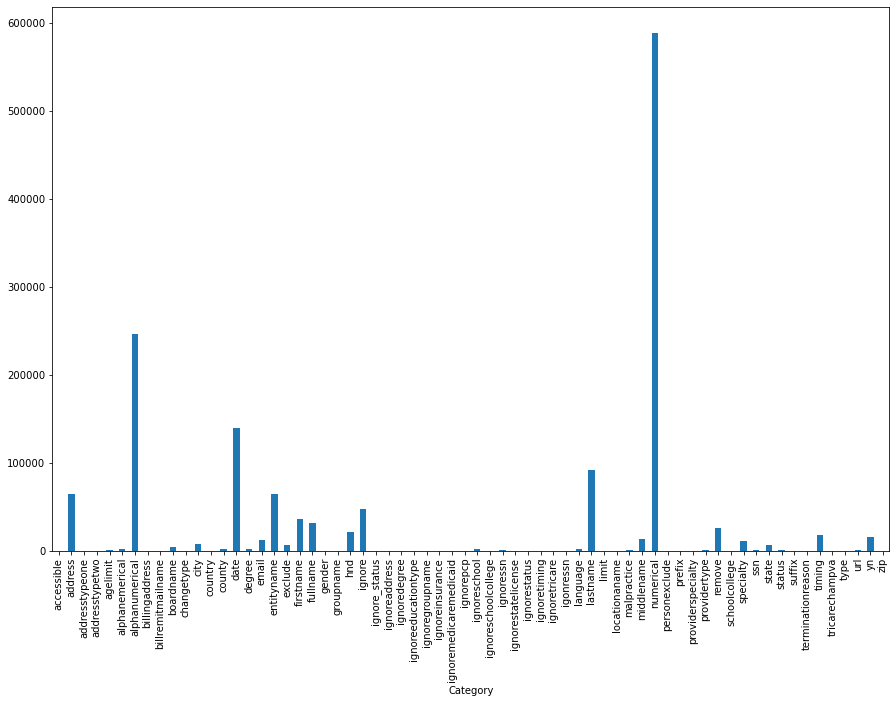

In [15]:
fig = plt.figure(figsize=(15,10))
new_df.groupby('Category').RoasterData.count().plot.bar(ylim=0)
plt.show()

In [16]:
new_df2=new_df.sample(frac=0.25, replace=True, random_state=1).copy()
#new_df2=new_df.sample(frac=0.01, replace=True, random_state=1).copy()

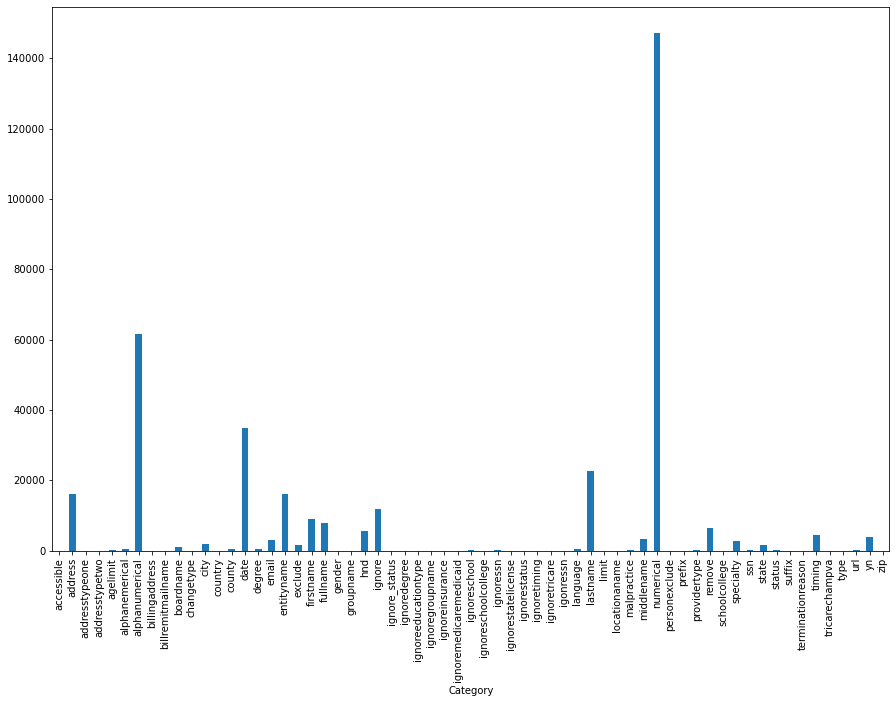

In [17]:
fig = plt.figure(figsize=(15,10))
new_df2.groupby('Category').RoasterData.count().plot.bar(ylim=0)
plt.show()

In [18]:
new_df2['Category_id'] = new_df2['Category'].factorize()[0]
category_id_df = new_df2[['Category', 'Category_id']].drop_duplicates().sort_values('Category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['Category_id', 'Category']].values)
new_df2.head()

,Category,RoasterData,Category_id
1301722,lastname,SKARIAH,0
6647458,fullname,Derrick A,1
6283163,alphanumerical,BV5037569,2
6646343,fullname,Buencamino,1
12416798,alphanumerical,A105218,2


In [19]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(new_df2.RoasterData).toarray()
labels = new_df2.Category_id
print ('features shape:',features.shape)

features shape: (366579, 15003)


In [20]:
#d = []
#N = 2
#for Category, Category_id in sorted(category_to_id.items()):
  #features_chi2 = chi2(features, labels == Category_id)
  #indices = np.argsort(features_chi2[0])
  #feature_names = np.array(tfidf.get_feature_names())[indices]
  #unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  #bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  #d.append(
        #{
            #'Category': Category,
            #'MostCorrelatedUnigrams': unigrams[-N:],
            #'MostCorrelatedBigrams':  bigrams[-N:]
        #}
    #)
  #print(color.GREEN + color.BOLD + color.UNDERLINE + Category + color.END)
  #print(color.BLUE + "Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  #print(color.YELLOW + "Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
#dfCorr=pd.DataFrame(d)
#pd.to_pickle(dfCorr, "dfCorr.pkl")

In [21]:
dfCorr = pd.read_pickle("dfCorr.pkl")
print ('dfCorr.shape',dfCorr.shape)
dfCorr.head(10)

dfCorr.shape (63, 3)


,Category,MostCorrelatedUnigrams,MostCorrelatedBigrams
0,accessible,"[exam, eb]","[medical center, 00 00]"
1,address,"[box, ste]","[greenway plaza, po box]"
2,addresstypeone,"[mailing, secondary]","[ssp additional, practice address]"
3,addresstypetwo,"[vmg, additional]","[place service, practice location]"
4,agelimit,"[yrs, years]","[16 years, 18 years]"
5,alphanemerical,"[4250, 4662]","[medical center, 00 00]"
6,alphanumerical,"[c1, 35]","[00 00, aprn cnp]"
7,billingaddress,"[2939, file]","[medical center, 00 00]"
8,billremitmailname,"[fund, haz1040025509]","[self insured, self insurance]"
9,boardname,"[american, board]","[board internal, american board]"


Observations on Data
----------------------
1. Original data uses !@~!@ as a delimeter that has been replaced with comma and then comma separated values in rows
2. There are over all 66 categories
3. Data is imbalanced as we have got few categories that have got only singe digit rows
4. Due to limitation of data classification model may not learn for all catgories
5. Taking a subset of data that have >=5000 rows for each category


In [22]:
#Selecting only those Categories that have > 5000 records
new_df=new_df.groupby('Category').filter(lambda x: len(x) >= 1000)
#new_df=new_df[new_df['RoasterData'].isin(filtered)]
print('new_df shape after filtering:', new_df.shape)

new_df shape after filtering: (1461564, 2)


In [23]:
new_df['Category'].value_counts()

numerical         588851
alphanumerical    246992
date              139759
lastname           91544
address            64131
entityname         63930
ignore             46897
firstname          35943
fullname           31204
remove             26347
hnd                21652
timing             17676
yn                 15645
middlename         12746
email              12579
specialty          11188
city                7707
state               6695
exclude             6217
boardname           3781
alphanemerical      1957
county              1859
degree              1847
language            1733
ignoreschool        1385
status              1299
Name: Category, dtype: int64

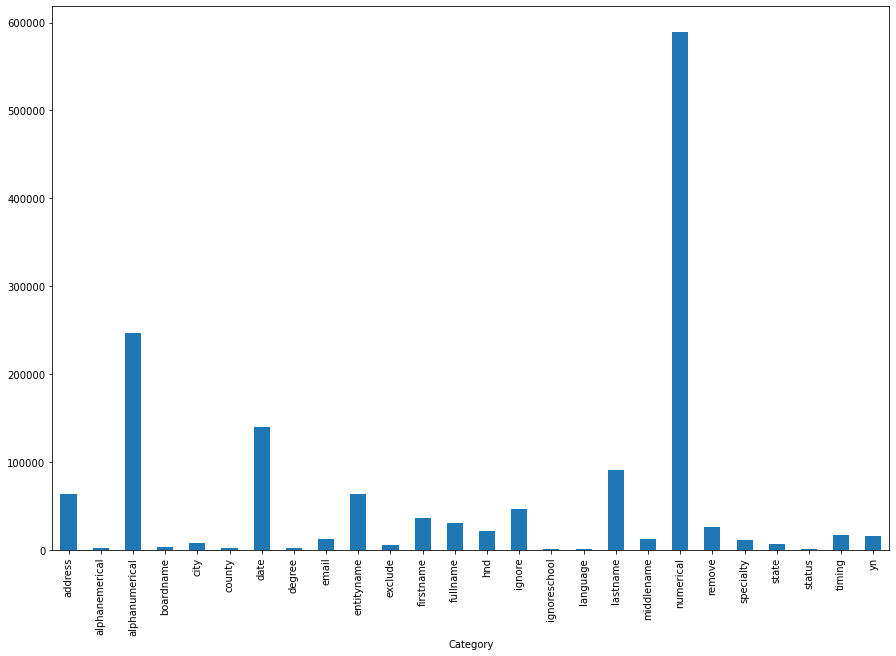

In [24]:
fig = plt.figure(figsize=(15,10))
new_df.groupby('Category').RoasterData.count().plot.bar(ylim=0)
plt.show()

Pre processing on data before sending it to ML model
----------------
1. Clean Text
2. Tokenization using TF-IDF vectors
3. Training and Test split
4. Cross Validation using K Fold

In [25]:
import re


def clean_text(text):
    """
    Applies some pre-processing on the given text.

    Steps :
    - Removing HTML tags
    - Removing punctuation
    - Lowering text
    """
    
    # remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # remove the characters [\], ['] and ["]
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)    
    
    # convert text to lowercase
    text = text.strip().lower()
    
    # replace punctuation characters with spaces
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)

    return text

In [26]:
X=new_df[['RoasterData']].copy()
y=new_df[['Category']].copy()

In [27]:
# Label Encoding categorical data for the classification category
#from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#labelencoder_Y = LabelEncoder()
#y = labelencoder_Y.fit_transform(y)
#filehandler = open("labelencoder_Y.obj","wb")
#joblib.dump(labelencoder_Y,filehandler)
#filehandler.close()

#print(y)
#print(np.unique(y, return_counts=True))

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# Transform each text into a vector of word counts
#vectorizer = CountVectorizer(stop_words="english",preprocessor=clean_text)
vectorizer = TfidfVectorizer(stop_words="english",preprocessor=clean_text,ngram_range=(1, 2))
training_features = vectorizer.fit_transform(X_train["RoasterData"])    
test_features = vectorizer.transform(X_test["RoasterData"])
print('training_features.shape',training_features.shape)
print('test_features.shape',test_features.shape)

training_features.shape (1169251, 1113240)
test_features.shape (292313, 1113240)


In [30]:
# Training
model = LinearSVC()
model.fit(training_features, y_train)
y_pred = model.predict(test_features)

/Users/sislam14/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [31]:
# Evaluation
acc = accuracy_score(y_test, y_pred)
print("Accuracy of Model: {:.2f}".format(acc*100))
y_pred

Accuracy of Model: 56.92


array(['numerical', 'specialty', 'numerical', ..., 'firstname', 'timing',
       'numerical'], dtype=object)

In [ ]:
#K-Fold validation
scores = cross_val_score(model, training_features, y_train["Category"], cv=5)
scores

Saving the model and vectorizer as pickle file so that it can be used in the api
-----------------------------

In [ ]:
joblib.dump(vectorizer, 'tfidfVectorizer.pkl')
joblib.dump(model,'nlpLinearSVCModel.pkl')

Loading the pickle file of model and vectorizer and passing input to predict
-------------------

In [ ]:
data = {'RoasterData': ['Orthopedics']}
X=pd.DataFrame.from_dict(data)
vectorizer_load = joblib.load('tfidfVectorizer.pkl')
model_load = joblib.load('nlpLinearSVCModel.pkl')
predict_features = vectorizer_load.transform(X["RoasterData"])
y_pred = model_load.predict(predict_features)
y_pred

In [ ]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, training_features, y_train, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()